In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np




# Define log file path
log_file_path = 'Data/RFpredictions/__BackTesting.log'

# Initialize list to store parsed data
data = []

# Define a regex pattern to extract data
pattern_trade = re.compile(r'(\d{4}-\d{2}-\d{2}) \d{2}:\d{2}:\d{2} INFO: Filename: (.*), (Buy|Sell) Order Executed - Size: (.*), Price: (.*), Value: (.*)')
pattern_closed = re.compile(r'(\d{4}-\d{2}-\d{2}) \d{2}:\d{2}:\d{2} INFO: Filename: (.*), Trade Closed - EntryDate: (\d{4}-\d{2}-\d{2}), ExitDate: (\d{4}-\d{2}-\d{2}), Duration: (\d+) days, PnL: (.*), Mean Close Price: (.*), Std Dev Close Price: (.*)')

trades = []
current_trade = {}

with open(log_file_path, 'r') as file:
    for line in file:
        match_trade = pattern_trade.search(line)
        match_closed = pattern_closed.search(line)
        if match_trade:
            timestamp, filename, action, size, price, value = match_trade.groups()
            current_trade = {
                'Timestamp': timestamp,
                'Filename': filename,
                'Action': action,
                'Size': float(size),
                'Price': float(price),
                'Value': float(value)
            }
        elif match_closed:
            timestamp, filename, entry_date, exit_date, duration, pnl, mean_close, std_dev_close = match_closed.groups()
            current_trade.update({
                'EntryDate': entry_date,
                'ExitDate': exit_date,
                'Duration': int(duration),
                'PnL': float(pnl),
                'Mean Close Price': float(mean_close),
                'Std Dev Close Price': float(std_dev_close)
            })
            trades.append(current_trade)
            current_trade = {}

df = pd.DataFrame(trades)



def printstats(df):
    profitable_trades = df[df['PnL'] > 0]
    unprofitable_trades = df[df['PnL'] < 0]

    ##count the nnumber of trades that are buys and sells
    buys = df[df['Action'] == 'Buy']
    sells = df[df['Action'] == 'Sell']
    average_duration_all = df['Duration'].mean()
    average_duration_profitable = profitable_trades['Duration'].mean()
    average_duration_unprofitable = unprofitable_trades['Duration'].mean()


    total_profit = profitable_trades['PnL'].sum()
    total_loss = unprofitable_trades['PnL'].sum()

    average_profit_per_trade = total_profit / len(profitable_trades) if len(profitable_trades) > 0 else 0
    average_loss_per_trade = total_loss / len(unprofitable_trades) if len(unprofitable_trades) > 0 else 0



    stats = {
        "Total Trades": len(profitable_trades) + len(unprofitable_trades),
        "Number of Profitable Trades": len(profitable_trades),
        "Number of Unprofitable Trades": len(unprofitable_trades),
        "Profitable Percentage": len(profitable_trades) / (len(profitable_trades) + len(unprofitable_trades))*100,
        "Average Duration All Trades (days)": average_duration_all,
        "Average Duration Profitable Trades (days)": average_duration_profitable,
        "Average Duration Unprofitable Trades (days)": average_duration_unprofitable,

        "Mean Profit": profitable_trades['PnL'].mean(),
        "Mean Loss": unprofitable_trades['PnL'].mean(),
        "Median Profit": profitable_trades['PnL'].median(),
        "Median Loss": unprofitable_trades['PnL'].median(),


        "sum of unprofitable trades": total_loss,
        "sum of profitable trades": total_profit,

        "most consecutive profitable trades": df['PnL'].gt(0).cumsum().value_counts().max(),
        "most consecutive unprofitable trades": df['PnL'].lt(0).cumsum().value_counts().max(),

        "Average Profit per Trade": average_profit_per_trade,
        "Average Loss per Trade": average_loss_per_trade,

        "Average Profit for all Trades": df['PnL'].mean(),
        "Standard Deviation of Profits": profitable_trades['PnL'].std(),
        "Standard Deviation of Losses": unprofitable_trades['PnL'].std(),
        "Highest Profit": profitable_trades['PnL'].max(),
        "Highest Loss": unprofitable_trades['PnL'].min(),
        "Total PnL": df['PnL'].sum(),
        "Profit Factor": profitable_trades['PnL'].sum() / -unprofitable_trades['PnL'].sum(),
        "Yearly Return": df['PnL'].sum()/5000*100,

    }

    # Print formatted table
    print("Trading Performance Statistics:")
    print("-------------------------------------------------")
    for key, value in stats.items():
        print(f"{key}: {value:.2f}")
    print("-------------------------------------------------")


    ##dynamically set the number of bins to be the square root of the number of trades
    binsNumber = int(np.sqrt(len(df)))*5




    plt.figure(figsize=(15, 6))
    sns.histplot(profitable_trades['PnL'], color='green', label='Profitable Trades', kde=True, bins=binsNumber, stat='density')
    sns.histplot(unprofitable_trades['PnL'], color='red', label='Unprofitable Trades', kde=True, bins=binsNumber, stat='density')
    plt.title('Normalized Distribution of Profitable vs Unprofitable Trades')
    plt.xlabel('PnL')
    plt.ylabel('Density')
    ##plt.yscale('log')  # Log scale for the y-axis
    plt.legend()
    plt.show()





def plot_performance(df):
    profitable_trades = df[df['PnL'] > 0.1]
    unprofitable_trades = df[df['PnL'] < 0.1]
    # PnL vs. Trade Characteristics
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    sns.scatterplot(ax=axes[1], data=df, x='Mean Close Price', y='PnL')
    axes[1].set_title('PnL vs. Mean Close Price')

    sns.scatterplot(ax=axes[2], data=df, x='Std Dev Close Price', y='PnL')
    axes[2].set_title('PnL vs. Std Dev Close Price')
    plt.show()

    # positive pnl vs mean close price
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    sns.scatterplot(ax=axes[1], data=profitable_trades, x='Mean Close Price', y='PnL')
    axes[1].set_title('Positive PnL vs. Mean Close Price')
    
    # negative pnl vs mean close price
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    sns.scatterplot(ax=axes[1], data=unprofitable_trades, x='Mean Close Price', y='PnL')
    axes[1].set_title('Negative PnL vs. Mean Close Price')
    plt.show()


printstats(df)
##plot_performance(df)

KeyError: 'PnL'

Profitable Trades Statistics:

         PnL  Mean Close Price  Std Dev Close Price
count   4.00              4.00                 4.00
mean  445.60              4.52                 1.45
std   447.99              5.20                 1.53
min    44.00              1.53                 0.36
25%    64.66              1.85                 0.40
50%   449.97              2.12                 0.89
75%   830.92              4.78                 1.93
max   838.47             12.31                 3.64

Unprofitable Trades Statistics:

          PnL  Mean Close Price  Std Dev Close Price
count   10.00             10.00                10.00
mean  -143.22              5.05                 2.98
std    107.40              2.89                 2.86
min   -348.27              1.74                 0.52
25%   -209.13              2.64                 0.99
50%   -117.30              4.33                 1.95
75%    -58.07              7.02                 3.93
max    -30.20             10.32            

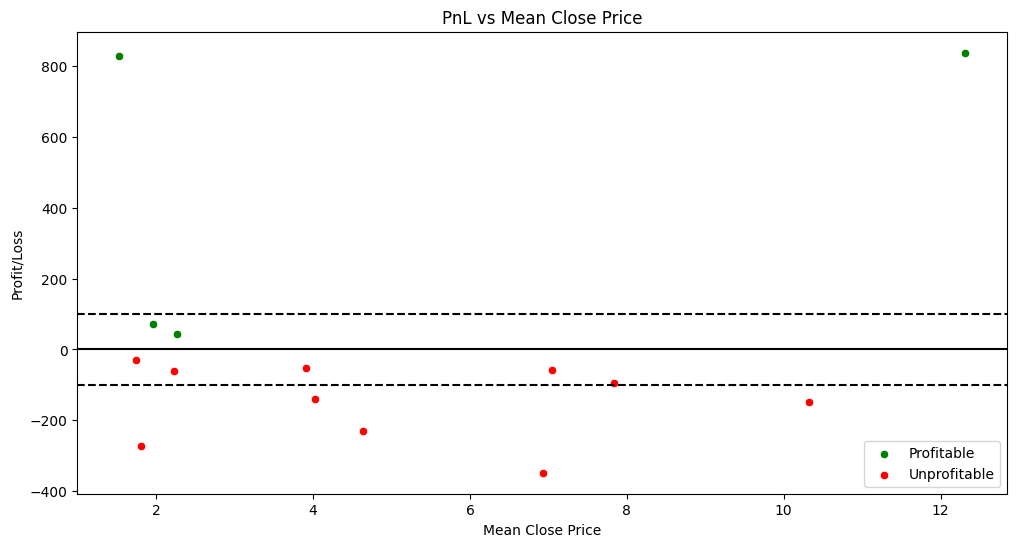

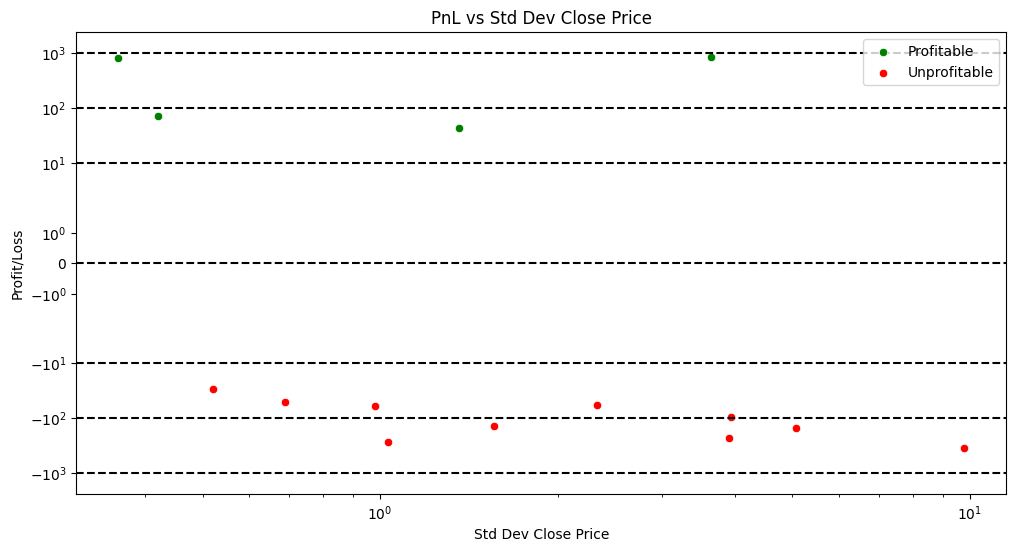

In [9]:
# Reading the log file and parsing the trade data
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns


# File path
log_file_path = 'Data/RFpredictions/__BackTesting.log'

# Define regex pattern to extract trade data
pattern = re.compile(r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}) INFO: Filename: (.*), Trade Closed - EntryDate: (.*), ExitDate: (.*), Duration: (\d+) days, PnL: (.*), Mean Close Price: (.*), Std Dev Close Price: (.*)')

# Initialize list to store parsed data
data = []

# Open the file and parse data
with open(log_file_path, 'r') as file:
    for line in file:
        match = pattern.search(line)
        if match:
            timestamp, filename, entry_date, exit_date, duration, pnl, mean_close, std_dev_close = match.groups()
            data.append({
                'Timestamp': timestamp,
                'Filename': filename,
                'EntryDate': entry_date,
                'ExitDate': exit_date,
                'Duration': int(duration),
                'PnL': float(pnl),
                'Mean Close Price': float(mean_close),
                'Std Dev Close Price': float(std_dev_close)
            })

# Convert to DataFrame
df = pd.DataFrame(data)






# Separate data into profitable and unprofitable trades
profitable_trades = df[df['PnL'] > 0]
unprofitable_trades = df[df['PnL'] < 0]


# Set display options for better formatting
pd.set_option('display.float_format', '{:.2f}'.format)  # Format floats to two decimal places
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Set the display width for better readability
pd.set_option('display.max_colwidth', None)  # Show full length of the column content

# Printing the dataframes with better formatting
print("Profitable Trades Statistics:\n")
print(profitable_trades[['PnL', 'Mean Close Price', 'Std Dev Close Price']].describe().to_string(index=True))

print("\nUnprofitable Trades Statistics:\n")
print(unprofitable_trades[['PnL', 'Mean Close Price', 'Std Dev Close Price']].describe().to_string(index=True))




profitable_trades = df[df['PnL'] > 0]
unprofitable_trades = df[df['PnL'] < 0]

# Visualizing the relationship between PnL and Mean Close Price
plt.figure(figsize=(12, 6))
sns.scatterplot(data=profitable_trades, x='Mean Close Price', y='PnL', color='green', label='Profitable')
sns.scatterplot(data=unprofitable_trades, x='Mean Close Price', y='PnL', color='red', label='Unprofitable')
plt.title('PnL vs Mean Close Price')
##put a dahsed line at 100 
plt.axhline(100, color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='-')

plt.axhline(-100, color='black', linestyle='--')
plt.xlabel('Mean Close Price')
plt.ylabel('Profit/Loss')
plt.legend()
plt.show()

# Visualizing the relationship between PnL and Standard Deviation of Close Price
plt.figure(figsize=(12, 6))
sns.scatterplot(data=profitable_trades, x='Std Dev Close Price', y='PnL', color='green', label='Profitable')
sns.scatterplot(data=unprofitable_trades, x='Std Dev Close Price', y='PnL', color='red', label='Unprofitable')
##make a horizontal line at 10 




plt.title('PnL vs Std Dev Close Price')
plt.xlabel('Std Dev Close Price')
plt.ylabel('Profit/Loss')
##put a middle line at 0 
plt.axhline(0, color='black', linestyle='--')
plt.axhline(10, color='black', linestyle='--')
plt.axhline(100, color='black', linestyle='--')
plt.axhline(1000, color='black', linestyle='--')
plt.axhline(-10, color='black', linestyle='--')
plt.axhline(-100, color='black', linestyle='--')
plt.axhline(-1000, color='black', linestyle='--')
##change to log scale that works with negative numbers
plt.yscale('symlog')
##plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()



